In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

from ultralytics import YOLO

In [2]:
CLASSES = [21] #id bear
# DIRECTORY = 'dataset/valid/images/' #dataset wildlife from roboflow
# DIRECTORY = 'bear_pose_dataset/valid/images/' #https://universe.roboflow.com/object-u0yzm/bear_pose/dataset/3/images
DIRECTORY = 'DS_bears_test_handmade'

In [3]:
y = [1 if 'bear' in name else 0 for name in sorted(os.listdir(DIRECTORY))]

In [4]:
# # get y_data
# # 0 - no bear; 1 - has bear

# LABEL_DIRECTORY = 'dataset/valid/labels/'
# files = [os.path.join(LABEL_DIRECTORY, file[:-3] + 'txt') for file in os.listdir(DIRECTORY)]
# y = list()
# for file in files:
#     with open(file) as txt:
#         y.append(1 if [int(line.split()[0]) for line in txt.readlines() if line.split()[0] == '0'] else 0)
# y = np.array(y)

# Этот кусок кода использовался, если в представленном датасете есть не только медведи

In [5]:
def get_models(models: list[str]):
    result = dict()
    for model in models:
        result[model.split('.')[0]] = YOLO(model)
    return result

In [6]:
def get_y_conf(results) -> tuple[np.ndarray]:
    y_pred = list()
    y_conf = list()
    for result in results:
        if result.summary():
            y_pred.append(1)
            y_conf.append(result.summary()[0]['confidence'])
            continue
        y_pred.append(0)
        y_conf.append(0)
    return np.array(y_pred), np.array(y_conf)

In [7]:
#'synt_first.pt'
models = get_models(['yolov5nu', 
                     'yolov8n.pt', 
                     'yolov8s.pt', 
                     'yolov8m.pt', 
                     'yolov9t.pt', 
                     'yolov10n.pt', 
                     'yolov10s.pt', 
                     'yolov10m.pt', 
                     'yolov8l.pt', 
                     'yolov8x.pt', 
                     'yolov9c.pt', 
                     'yolov9e.pt', 
                     'yolov10l.pt', 
                     'yolov10x.pt', 
                     'rtdetr-l.pt',
                     'rtdetr-x.pt'])

100%|█████████████████████████████████████████████████████████████████████████| 5.31M/5.31M [00:01<00:00, 4.52MB/s]


100%|█████████████████████████████████████████████████████████████████████████| 6.25M/6.25M [00:01<00:00, 5.10MB/s]


100%|█████████████████████████████████████████████████████████████████████████| 21.5M/21.5M [00:02<00:00, 8.09MB/s]


100%|█████████████████████████████████████████████████████████████████████████| 49.7M/49.7M [00:05<00:00, 9.97MB/s]


100%|█████████████████████████████████████████████████████████████████████████| 4.74M/4.74M [00:01<00:00, 4.28MB/s]


100%|█████████████████████████████████████████████████████████████████████████| 5.59M/5.59M [00:01<00:00, 4.70MB/s]


100%|█████████████████████████████████████████████████████████████████████████| 15.9M/15.9M [00:02<00:00, 8.00MB/s]


100%|█████████████████████████████████████████████████████████████████████████| 32.1M/32.1M [00:03<00:00, 9.37MB/s]


100%|██████████████████████████████████████████████████████████████████████████| 83.7M/83.7M [01:33<00:00, 942kB/s]


100%|███████████████████████████████████████████████████████████████████████████| 131M/131M [00:12<00:00, 11.0MB/s]


100%|█████████████████████████████████████████████████████████████████████████| 49.4M/49.4M [00:05<00:00, 8.93MB/s]


100%|███████████████████████████████████████████████████████████████████████████| 112M/112M [00:10<00:00, 10.9MB/s]


100%|█████████████████████████████████████████████████████████████████████████| 50.0M/50.0M [00:05<00:00, 9.13MB/s]


100%|█████████████████████████████████████████████████████████████████████████| 61.4M/61.4M [00:06<00:00, 10.2MB/s]


100%|█████████████████████████████████████████████████████████████████████████| 63.4M/63.4M [00:06<00:00, 10.4MB/s]


100%|███████████████████████████████████████████████████████████████████████████| 129M/129M [00:12<00:00, 11.0MB/s]


In [13]:
y_pred_dict = dict()
y_conf_dict = dict()
for name, model in models.items():
    if name == 'synt_first': #костыль под то, что в дообученном медведь эт 0 класс, а не 21
        results = model(DIRECTORY, classes=[0], verbose=False)
    else:
        results = model(DIRECTORY, classes=CLASSES, verbose=False)
    y_pred_dict[name], y_conf_dict[name] = get_y_conf(results)

### Accuracy

In [14]:
def print_accuracy(y_pred_dict, y_true, save = False, file_name = 'accuracy.txt'):
    file = open(file_name, 'w') if save else None
        
    for model, y_pred in y_pred_dict.items():
        print(f'{model} acc: {(y_pred == y_true).mean()}', file=file)
        
    if save:
        print(f'accuracy metrics saved in {file_name}')
        file.close()

In [15]:
print_accuracy(y_pred_dict, y, save=False)

yolov5nu acc: 0.7361111111111112
yolov8n acc: 0.7777777777777778
yolov8s acc: 0.8472222222222222
yolov8m acc: 0.8888888888888888
yolov9t acc: 0.8055555555555556
yolov10n acc: 0.75
yolov10s acc: 0.8611111111111112
yolov10m acc: 0.9027777777777778
yolov8l acc: 0.9166666666666666
yolov8x acc: 0.9444444444444444
yolov9c acc: 0.8611111111111112
yolov9e acc: 0.9861111111111112
yolov10l acc: 0.9305555555555556
yolov10x acc: 0.9027777777777778
rtdetr-l acc: 0.2916666666666667
rtdetr-x acc: 0.3055555555555556


#### ConfMat

In [23]:
def factor(n) -> list[int]:
    Ans = []
    d = 2
    while d * d <= n:
        if n % d == 0:
            Ans.append(d)
            n //= d
        else:
            d += 1
    if n > 1:
        Ans.append(n)
    return Ans

def plot_conf_mat(y_pred_dict, y_true, rows_cols: tuple[int] | None = None, figsize: tuple[int] | None = None, save = False, file_name = 'ConfMat_plot.png'):
    if not rows_cols:
        rows, cols = factor(len(y_pred_dict)) #определяем кол-во строк и столбцов при помощи разложения на множители
    rows, cols = rows_cols
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    counter = 0
    for i in range(rows):
        for j in range(cols):
            model, y_pred = list(y_pred_dict.items())[counter]
            cm = confusion_matrix(y_true, y_pred)
            axs[i][j].set_title(model)
            ConfusionMatrixDisplay(cm).plot(ax=axs[i][j])
            counter +=1
    plt.tight_layout()
    if save:
        plt.savefig(file_name)

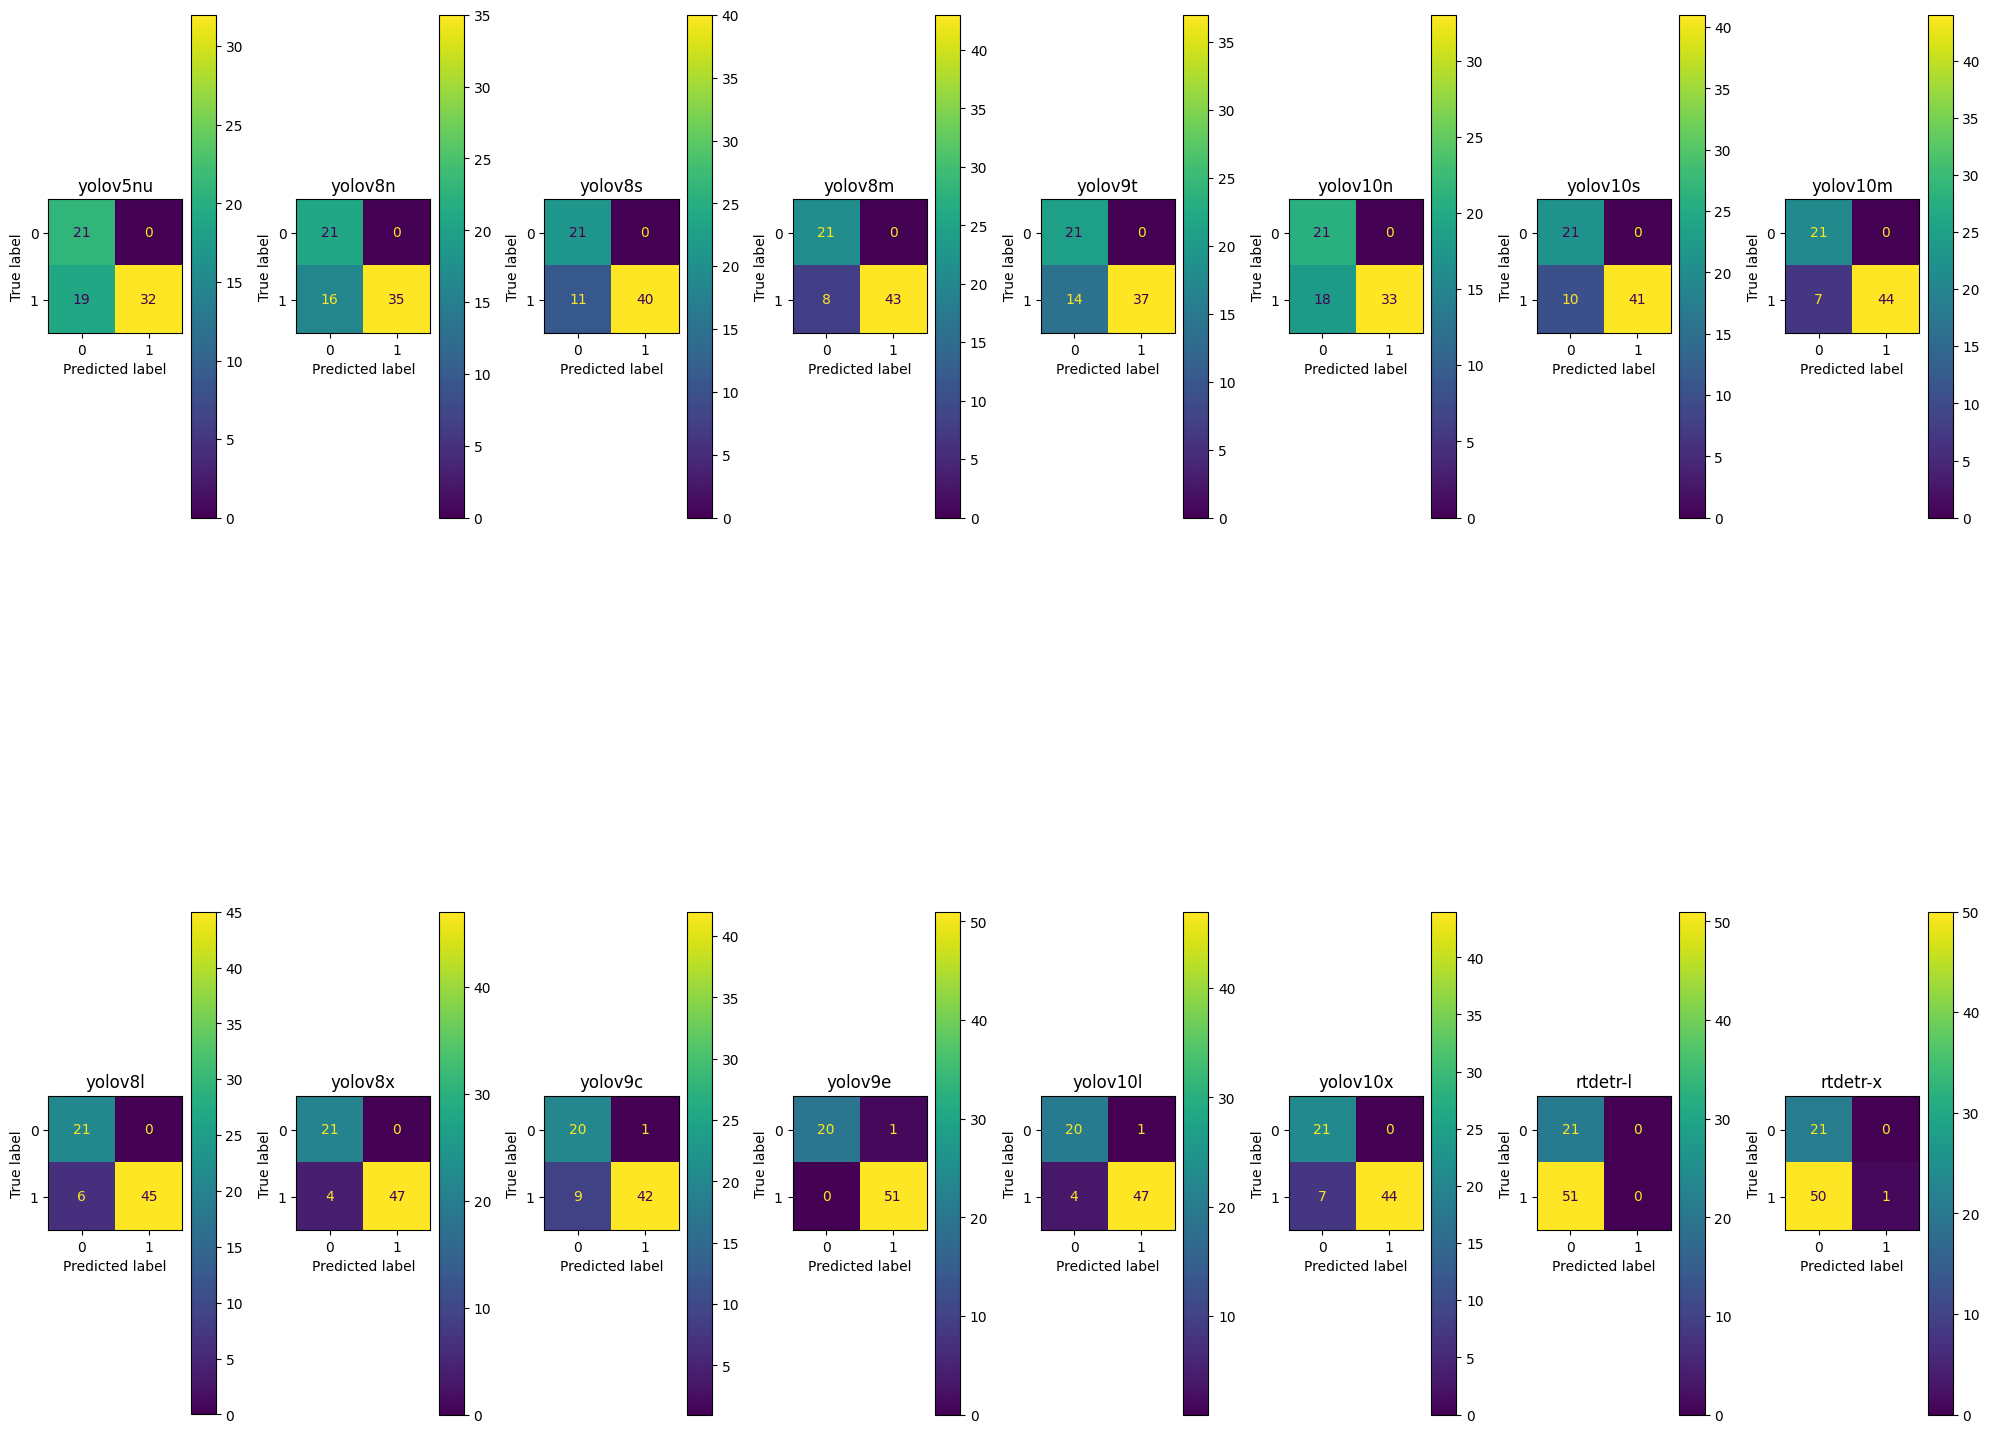

In [27]:
plot_conf_mat(y_pred_dict, y, rows_cols=(2, 8), figsize=(20, 20), save=False)

In [28]:
def plot_roc_curve(y_conf_dict, y_true, save = False, file_name = 'roc_curve.png'):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    for name, y_conf in y_conf_dict.items():
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_conf)
        roc_auc = metrics.auc(fpr, tpr)
        metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name).plot(ax=ax)
    
    ax.plot((0, 1), (0, 1), 
            label="Chance level (AUC = 0.5)",
            color="k",
            linestyle="--",)
    ax.legend()
    ax.set_title("Receiver Operating Characteristic (ROC) curves")
    ax.grid(linestyle="--")
    plt.tight_layout()

    if save:
        plt.savefig(file_name)

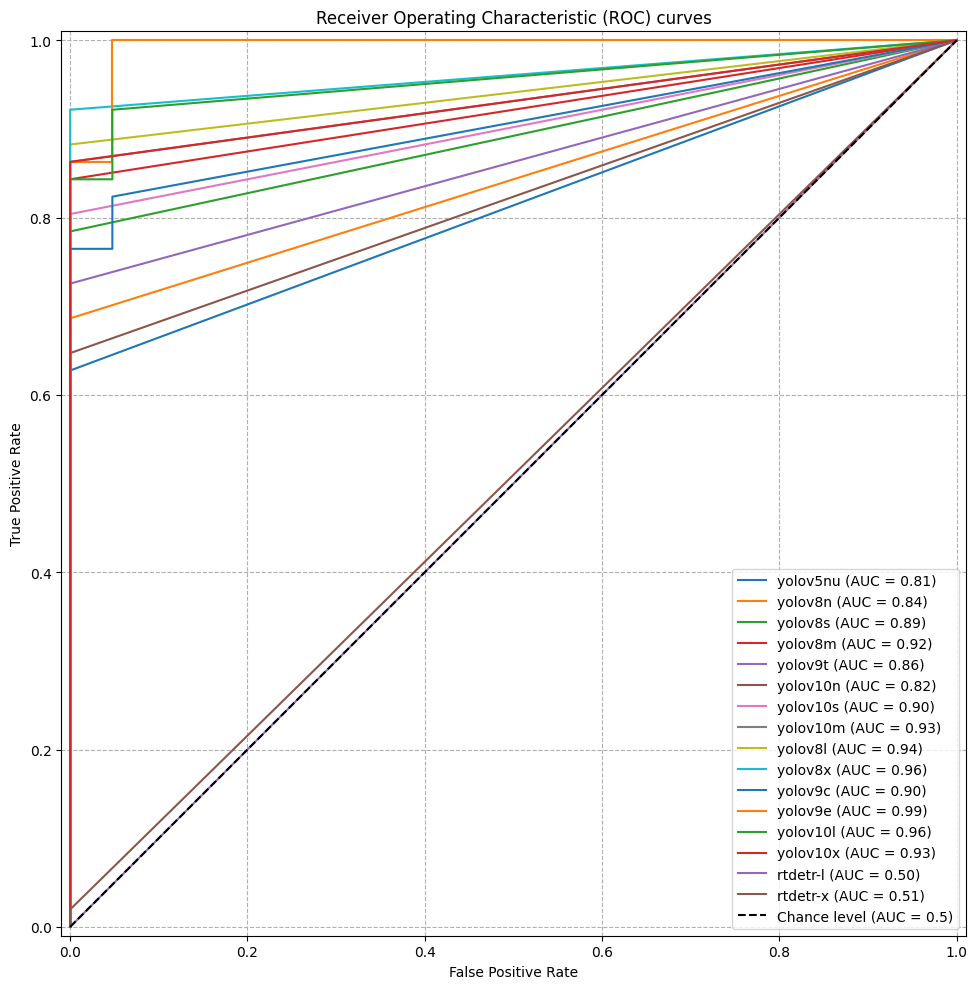

In [29]:
plot_roc_curve(y_conf_dict, y, save=False)